In [25]:
import os
import pandas as pd
import numpy as np
import math
import itertools
from matplotlib import pyplot as plt
from datetime import datetime
import sys
sys.path.append("/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages")

%matplotlib inline
import torch
from torch import nn, optim

In [26]:
stock_price = pd.read_excel('./dataset/tickerdata.xlsx',sheet_name= 'Sheet1', engine='openpyxl', index_col=[0])
# "PLTR","AAL","MVIS","GME","REAL"
stock_tickers = stock_price.filter(regex='^(?!Unnamed)').columns

new_col       = np.repeat(stock_tickers,5)
stock_price.columns = new_col
close_price         = stock_price.loc[:,stock_price.iloc[0,]=='Close']
open_price          = stock_price.loc[:,stock_price.iloc[0,]=='Open']
volume             = stock_price.loc[:,stock_price.iloc[0,]=='Volume']

close_price        = close_price.reset_index()
close_price        = close_price .drop(index = [0,1])
#.columns[0] = ['DATE']
close_price  = close_price.set_index('index')

daily_return_close2close = close_price.diff(1)/close_price

#daily_return_open2close = (close_price - open_price)/open_price
daily_return_open2close = close_price #(open_price - close_price.shift(1))/close_price.shift(1)

daily_return_open2close["sum_delta"] = (close_price - open_price).sum(axis=1)
daily_return_open2close["sum_opening"] = (open_price).sum(axis=1)

daily_return_open2close["sum_ratio"] = ((close_price - open_price)/open_price).sum(axis=1)

#daily_return_open2close["close"] = close_price




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.7/site-packages/pandas/core/indexes/base.py:3519: RuntimeWarning: '<' not supported between instances of 'float' and 'Timestamp', sort order is undefined for incomparable objects
  join_index = self.union(other)


In [3]:
#  trying to see if any of this works



In [27]:
daily_return_open2close= daily_return_open2close.fillna(0.0)

In [28]:
df_sent = pd.read_csv("./dataset/sentiment_by_ticker_filleddown.csv").set_index("timestamp")

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
my_cols = list(df_sent.columns)
my_new_cols = [ cc+"_sentiment" for cc in my_cols]
df_sent.columns = my_new_cols

In [30]:
print(df_sent)

                    PLTR_sentiment RKT_sentiment ONE_sentiment AMC_sentiment  \
timestamp                                                                      
2021-01-28 21:37:41            NaN           NaN           NaN           NaN   
2021-01-28 21:32:10            NaN           NaN           NaN           NaN   
2021-01-28 21:30:35            NaN           NaN           NaN           NaN   
2021-01-28 21:28:57            NaN           NaN           NaN           NaN   
2021-01-28 21:26:56            NaN           NaN           NaN      Positive   
...                            ...           ...           ...           ...   
2021-08-02 15:03:27       Positive       Neutral      Negative      Positive   
2021-08-02 15:01:03       Positive       Neutral      Negative      Positive   
2021-08-02 13:59:35       Positive       Neutral      Negative      Positive   
2021-08-02 13:00:16       Positive       Neutral      Negative      Positive   
2021-08-02 12:00:14       Positive      

In [31]:
df_sent.index = pd.to_datetime(df_sent.index)

In [32]:
#df_sent = df_sent.replace({'Positive':1,
#                        'Neutral':0,
#                        'Negative':-1})

In [33]:
df_sent['Day'] = df_sent.index.floor('D')

In [34]:
sorted_sentiment_daily_sum = df_sent.groupby('Day')["MVIS_sentiment"]#.value_counts()

In [35]:
sorted_sentiment_daily_sum
gme_sent_freq = df_sent.groupby(['Day','MVIS_sentiment']).size().unstack(fill_value=0)


In [36]:
daily_return_open2close["positive"] = gme_sent_freq["Positive"]
daily_return_open2close["negative"] = gme_sent_freq["Negative"]
daily_return_open2close["neutral"] = gme_sent_freq["Neutral"]

In [14]:
#daily_return_open2close
#close_price.drop(close_price.index[0], inplace=True)
#open_price.drop(open_price.index[0], inplace=True)#
#

In [15]:
#volume.drop(volume.index[0], inplace=True)

In [16]:
daily_return_open2close.drop(daily_return_open2close.index[-1], inplace=True)

In [37]:
print(daily_return_open2close)
nrows = daily_return_open2close.shape[0]

                 PLTR        RKT     ONE        AMC       REAL       SPCE  \
index                                                                       
2021-01-28  35.660000  18.920959  3.7700   8.630000  25.059999  43.110001   
2021-01-29  35.180000  18.965355  3.7400  13.260000  23.680000  44.290001   
2021-02-01  33.959999  19.125175  3.7000  13.300000  24.059999  53.790001   
2021-02-02  31.020000  18.592440  3.7300   7.820000  24.090000  48.580002   
2021-02-03  31.760000  18.832170  3.6700   8.970000  24.400000  57.119999   
...               ...        ...     ...        ...        ...        ...   
2021-08-09  22.930000  16.368509  0.7666  33.799999  16.230000  35.209999   
2021-08-10  22.920000  16.182714  0.7010  31.750000  13.310000  31.330000   
2021-08-11  22.350000  16.359221  0.6778  31.549999  14.290000  27.360001   
2021-08-12  24.889999  16.229162  0.6566  33.070000  14.020000  25.940001   
2021-08-13  24.900000  17.892025  0.6081  33.470001  13.340000  25.370001   

In [18]:
my_sent = daily_return_open2close[["MVIS","positive","neutral","negative"]]
my_sent.to_csv('MVIS_out.csv',index=False)

In [19]:
np_data_org = np.array(daily_return_open2close)
np_sent_org = np.array(my_sent)

In [21]:
print(daily_return_open2close.shape)

(137, 31)


In [22]:
np_data = np.reshape(np_data_org, (nrows,-1))
print(np_data.shape)

(137, 31)


In [23]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler  
# Let's scale this 
mm = MinMaxScaler()
ss = StandardScaler()
np_sent_scaled = mm.fit_transform(np_sent_org)
#np_data_scaled_tmp = ss.fit_transform(np_data)

In [24]:
print(np_sent_scaled[0])

[0.00672528        nan        nan        nan]


In [26]:
sequence_length = 3
# was originally this my_sent_data = np_data_scaled[-3:] #daily_return_open2close
my_sent_data = np_sent_scaled
data = daily_return_open2close
#print(list(data["GME"]))

In [27]:
#my_x_stock = data.iloc[:,8:9]
#my_x = data.iloc[:,-3:]
#my_x = my_x_stock + my_x_sent
#my_x = pd.concat([my_x_stock,my_x_sent], axis=1, join='inner')
#print(my_x)
#np_data_scaled = np_data[:,8]
np_data_scaled = np_data[:,8].reshape(len(np_data),1)

print(np_data_scaled[0])
np_data_scaled_tmp = mm.fit_transform(np_data_scaled)
print(np_data_scaled_tmp[0])
np_data_scaled = np_data_scaled_tmp
# combine the np_data_scaled + np_sent_scaled together. get 3 features + 1 target 
np_data_to_use = np.hstack((my_sent_data, np_data_scaled))
print(np_data_to_use[0])

[58815800]
[0.38744699]
[0.05966587 0.05905606 0.13174825 0.38744699]


                          PLTR       RKT       ONE        AMC      REAL  \
NaN                     Volume    Volume    Volume     Volume    Volume   
Date                       NaN       NaN       NaN        NaN       NaN   
2021-01-28 00:00:00   85250700  13670400    211416  591223900   8234300   
2021-01-29 00:00:00   42030900  21610100    230020  602193300   3605900   
2021-02-01 00:00:00   43460900   9663600    162701  434608000   3064400   
...                        ...       ...       ...        ...       ...   
2021-08-09 00:00:00   35611100   2433300  13298145   81054600   3495200   
2021-08-10 00:00:00   25947900   3778800   5683993  116181500  12099200   
2021-08-11 00:00:00   34679000   4098200   4869429   69684300   5188200   
2021-08-12 00:00:00  189287200  12973100   2742906   71050000   3880400   
2021-08-13 00:00:00   52395100  22014900   2707149   57990800   2557900   

                         SPCE        AMD        DD       GME      TSLA  ...  \
NaN                 

In [148]:
# stack the opening, close and volume 
np_open = np.array(open_price)[:,8].reshape(len(open_price),1)
np_close = np.array(close_price)[:,8].reshape(len(close_price),1)
np_vol = np.array(volume)[:,8].reshape(len(volume),1)

print(np_close)
print(np_vol.shape)
print(np_open.shape)
print(np_close.shape)

np_open_trans = ss.fit_transform(np_open)
np_close_trans = ss.fit_transform(np_close)
np_vol_trans = ss.fit_transform(np_vol)


np_data_to_use = np.hstack((np_open_trans[:136],np_vol_trans[:136],np_close_trans[:136]))
print(np_data_to_use)

[[225]
 [90]
 [92.41000366210938]
 [53.5]
 [63.77000045776367]
 [60]
 [50.31000137329102]
 [51.20000076293945]
 [51.09999847412109]
 [52.40000152587891]
 [49.5099983215332]
 [45.93999862670898]
 [40.68999862670898]
 [40.59000015258789]
 [46]
 [44.97000122070312]
 [91.70999908447266]
 [108.7300033569336]
 [101.7399978637695]
 [120.4000015258789]
 [118.1800003051758]
 [124.1800003051758]
 [132.3500061035156]
 [137.7400054931641]
 [194.5]
 [246.8999938964844]
 [265]
 [260]
 [264.5]
 [220.1399993896484]
 [208.1699981689453]
 [209.8099975585938]
 [201.75]
 [200.2700042724609]
 [194.4900054931641]
 [181.75]
 [120.3399963378906]
 [183.75]
 [181]
 [181.3000030517578]
 [194.4600067138672]
 [189.8200073242188]
 [191.4499969482422]
 [186.9499969482422]
 [184.5]
 [177.9700012207031]
 [170.2599945068359]
 [158.3600006103516]
 [141.0899963378906]
 [140.9900054931641]
 [166.5299987792969]
 [156.4400024414062]
 [154.6900024414062]
 [164.3699951171875]
 [158.5299987792969]
 [158.5099945068359]
 [151.16

In [871]:
# Prediction Index
index_Close = data.columns.get_loc("GME") #,"positive","negative","neutral"])
print(" index close {0}".format(index_Close))

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
# original train_data = np_data_scaled[0:train_data_len]
# original test_data = np_data_scaled[train_data_len - sequence_length:]

train_data = np_data_to_use[0:train_data_len]
test_data = np_data_to_use[train_data_len - sequence_length:]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    
    # apply scaling here, # undo if not desired
    #data = temp_data
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:3]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, -1]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(len(x_train[0]))
print(x_train[0])

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print((x_train[0][sequence_length-1][0]))
print(y_train[0])

 index close 8
2
[[0.05966587 0.05905606 0.13174825]
 [1.         1.         1.        ]]
(109, 2, 3) (109,)
(27, 2, 3) (27,)
1.0
0.08469584012044354


In [28]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)


X_ss, y_mm = split_sequences(my_sent_data, np_data_scaled, 20, 2) # use three days to predict next 2
print(X_ss.shape, y_mm.shape)

(116, 20, 3) (116, 2)


In [149]:
#####################################################
##### TESTING SPLIT OF DATA # define input sequence
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(np_data_to_use,3)
print(np_data_to_use[2:4])
print("---")
print(X_ss.shape)
print(y_mm.shape)
#######################################

[[ 2.39190081  0.98428274 -1.42264382]
 [-0.58563151  2.85465857 -2.12405981]]
---
(134, 3, 2)
(134,)


In [150]:
#assert y_mm[0].all() == np_data_scaled[2:4].squeeze(1).all()
#print(y_mm[0])
#print(np_data_scaled[2:4].squeeze(1))#.all()


total_samples = len(X_ss)
train_test_cutoff = round(0.80 * total_samples)

x_train = X_ss[:train_test_cutoff]
x_test = X_ss[train_test_cutoff:]

y_train = y_mm[:train_test_cutoff]
y_test = y_mm[train_test_cutoff:] 

print("Training Shape:", x_train.shape, y_train.shape)
print("Testing Shape:", x_test.shape, y_test.shape)
print(x_train[:3])

Training Shape: (107, 3, 2) (107,)
Testing Shape: (27, 3, 2) (27,)
[[[ 1.51862688  1.96683183]
  [ 3.46147501  1.58865293]
  [ 2.39190081  0.98428274]]

 [[ 3.46147501  1.58865293]
  [ 2.39190081  0.98428274]
  [-0.58563151  2.85465857]]

 [[ 2.39190081  0.98428274]
  [-0.58563151  2.85465857]
  [-1.07257138  1.22799008]]]


In [151]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable

In [152]:

'''
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)

x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)
'''
x_train = np.where(np.isnan(x_train), 0, x_train)
y_train = np.where(np.isnan(y_train), 0, y_train)
x_test = np.where(np.isnan(x_test), 0, x_test)
y_test = np.where(np.isnan(y_test), 0, y_test)

In [153]:
x_train_tensors = Variable(torch.Tensor(x_train))
x_test_tensors = Variable(torch.Tensor(x_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [154]:
print(x_train_tensors)

tensor([[[ 1.5186e+00,  1.9668e+00],
         [ 3.4615e+00,  1.5887e+00],
         [ 2.3919e+00,  9.8428e-01]],

        [[ 3.4615e+00,  1.5887e+00],
         [ 2.3919e+00,  9.8428e-01],
         [-5.8563e-01,  2.8547e+00]],

        [[ 2.3919e+00,  9.8428e-01],
         [-5.8563e-01,  2.8547e+00],
         [-1.0726e+00,  1.2280e+00]],

        [[-5.8563e-01,  2.8547e+00],
         [-1.0726e+00,  1.2280e+00],
         [-1.4252e+00,  2.1324e+00]],

        [[-1.0726e+00,  1.2280e+00],
         [-1.4252e+00,  2.1324e+00],
         [-2.0544e+00,  2.9996e+00]],

        [[-1.4252e+00,  2.1324e+00],
         [-2.0544e+00,  2.9996e+00],
         [-1.7433e+00,  4.4817e-01]],

        [[-2.0544e+00,  2.9996e+00],
         [-1.7433e+00,  4.4817e-01],
         [-2.0109e+00,  5.0115e-01]],

        [[-1.7433e+00,  4.4817e-01],
         [-2.0109e+00,  5.0115e-01],
         [-2.1098e+00,  9.4178e-01]],

        [[-2.0109e+00,  5.0115e-01],
         [-2.1098e+00,  9.4178e-01],
         [-2.1227e+00,

In [155]:
#reshaping to rows, timestamps, features
x_train_tensors_final = x_train_tensors# torch.reshape(x_train_tensors, (x_train_tensors.shape[0], sequence_length, x_train_tensors.shape[2]))
x_test_tensors_final = x_test_tensors #torch.reshape(x_test_tensors, (x_test_tensors.shape[0], sequence_length, x_test_tensors.shape[2])) 

print("Training Shape", x_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", x_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([107, 3, 2]) torch.Size([107])
Testing Shape torch.Size([27, 3, 2]) torch.Size([27])


In [156]:
print(x_train_tensors_final[0])
#np.nan_to_num(x_train_tensors_final)
#x_train_tensors_final = np.where(np.isnan(x_train_tensors_final), 0, x_train_tensors_final)
#y_train_tensors = np.where(np.isnan(y_train_tensors), 0, y_train_tensors)
#print(x_train_tensors_final)

tensor([[1.5186, 1.9668],
        [3.4615, 1.5887],
        [2.3919, 0.9843]])


In [157]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, dropout=0.5) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc_2 = nn.Linear(128, num_classes) #fully connected last layer

        #self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.relu = nn.LeakyReLU()
        #self.lin = nn.Linear(hidden_size, num_classes)
    
    def forward(self,x):
        #print(x.size(0))
        h_0 = Variable(torch.rand(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.rand(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        #print(x)
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #out,_ = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #print(out)
        
        #print(hn)
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc_2(out) #Final Output
        return out
    
        #lstm_output, hidden = self.lstm(x, hidden)
        #drop_output = self.dropout(lstm_output)
        #drop_output = drop_output.contiguous().view(-1, self.num_hidden)
        #final_out = self.fc_linear(drop_output)
        #return final_out, hidden

In [158]:
num_epochs =15000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 2 #number of features
hidden_size = 8 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
print(x_train_tensors_final.shape[2])

2


In [159]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, sequence_length) #our lstm class 

/usr/local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [160]:
print(lstm1)

LSTM1(
  (lstm): LSTM(2, 8, batch_first=True, dropout=0.5)
  (fc_1): Linear(in_features=8, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
  (tanh): Tanh()
  (relu): LeakyReLU(negative_slope=0.01)
)


In [161]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.SGD(lstm1.parameters(), lr=learning_rate, weight_decay=0.0001, momentum=0.9) 
print(x_train_tensors_final.shape)

torch.Size([107, 3, 2])


In [162]:
#print(list(np.nan_to_num(x_train_tensors_final)))

In [163]:
for epoch in range(num_epochs):
    #print(outputs)
    lstm1.train()
    outputs = lstm1.forward(x_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    #print(outputs.shape)
    # obtain the loss function
    #print(outputs)
    loss = criterion(outputs, y_train_tensors)
    #if epoch == 1: break 
        
    loss.backward() #calculates the loss of the loss function
    #torch.nn.utils.clip_grad_norm_(lstm1.parameters(), 100)
    #lstm1.float() # add this here

    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss)) #.item())) 
        print(outputs.shape)
        print(outputs.view(1, -1).shape)

/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([107])) that is different to the input size (torch.Size([107, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, loss: 1.24358
torch.Size([107, 1])
torch.Size([1, 107])
Epoch: 100, loss: 1.22774
torch.Size([107, 1])
torch.Size([1, 107])
Epoch: 200, loss: 1.22774
torch.Size([107, 1])
torch.Size([1, 107])
Epoch: 300, loss: 1.22773
torch.Size([107, 1])
torch.Size([1, 107])
Epoch: 400, loss: 1.22772
torch.Size([107, 1])
torch.Size([1, 107])
Epoch: 500, loss: 1.22772
torch.Size([107, 1])
torch.Size([1, 107])
Epoch: 600, loss: 1.22772
torch.Size([107, 1])
torch.Size([1, 107])
Epoch: 700, loss: 1.22771
torch.Size([107, 1])
torch.Size([1, 107])
Epoch: 800, loss: 1.22772
torch.Size([107, 1])
torch.Size([1, 107])
Epoch: 900, loss: 1.22772
torch.Size([107, 1])
torch.Size([1, 107])
Epoch: 1000, loss: 1.22770
torch.Size([107, 1])
torch.Size([1, 107])
Epoch: 1100, loss: 1.22770
torch.Size([107, 1])
torch.Size([1, 107])
Epoch: 1200, loss: 1.22770
torch.Size([107, 1])
torch.Size([1, 107])
Epoch: 1300, loss: 1.22769
torch.Size([107, 1])
torch.Size([1, 107])
Epoch: 1400, loss: 1.22770
torch.Size([107, 1]

In [1256]:
train_predict = lstm1.forward(x_train_tensors_final)#forward pass
print(train_predict.shape)
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y_train_tensors.data.numpy().reshape(-1, 1)

torch.Size([103, 1])


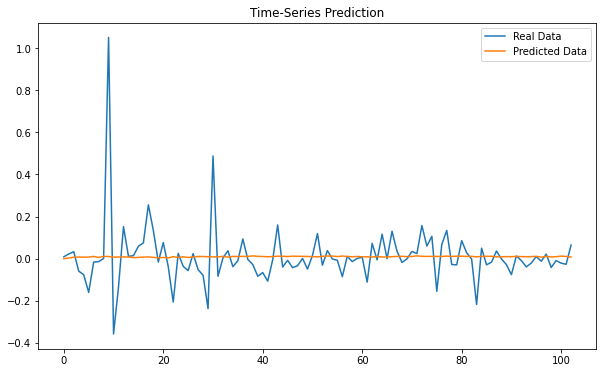

In [1257]:
data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
#plt.axvline(x=len(train_predict), c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Real Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

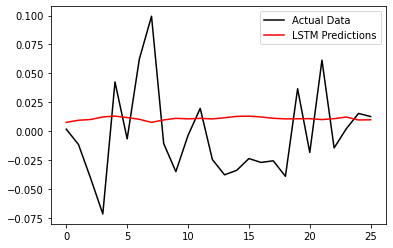

[[0.0077565815299749374], [0.009539049118757248], [0.010209931060671806], [0.012420224957168102], [0.01315292902290821], [0.011881371960043907], [0.010392474010586739], [0.0077249277383089066], [0.009835545904934406], [0.01123022474348545], [0.010754416696727276], [0.01120411604642868], [0.010709970258176327], [0.011735677719116211], [0.012925197370350361], [0.013119572773575783], [0.012386256828904152], [0.011274714022874832], [0.010734114795923233], [0.010813313536345959], [0.01096123456954956], [0.010130250826478004], [0.0109556894749403], [0.012334302067756653], [0.009803018532693386], [0.009968534111976624]]


In [1258]:
test_predict = lstm1.forward(x_test_tensors_final) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict.tolist()

test_target = y_test_tensors.detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data", c='k')
plt.plot(test_predict, label="LSTM Predictions",c='r')
plt.savefig("small_plot.png", dpi=300)
plt.legend()
plt.show()

print(test_predict)
